```
This software is part of GPU Ocean. 

Copyright (C) 2019  SINTEF Digital

Creating fan plots for plotting drift trajectory forecasts.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Plotting of drift trajectory forecasts


## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from scipy.special import lambertw

import os
import sys
from importlib import reload

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'

#Import our simulator
from SWESimulators import CDKLM16, PlotHelper, Common, IPythonMagic
from SWESimulators import CDKLM16, Common, DoubleJetCase, GPUDrifterCollection, Observation



In [2]:
%cuda_context_handler gpu_ctx

# Create a simulator

... so that we have relevant parameters available. Most efficient to read one of the initial states.

In [3]:
%%time
sim_path = os.path.abspath('double_jet_ensemble_init/double_jet_case_00.nc')
sim = CDKLM16.CDKLM16.fromfilename(gpu_ctx, sim_path, cont_write_netcdf=False)


Wall time: 4.9 s


# Define filenames and read drifter positions

In [4]:
os.listdir('scripts/')
script_path = os.path.abspath('scripts/fanplotdemo')
truth_files = []
for subfolder in os.listdir('scripts/fanplotdemo/'):
    if subfolder.startswith('truth_2019_04_15-09'):
        drifter_file_name = os.path.join(os.path.join(script_path, subfolder),
                                         'drifter_observations.pickle')
        
        truth_files.append(drifter_file_name)
        
print(len(truth_files))

20


In [5]:
observations = []
main_obs = Observation.Observation()
main_obs.read_pickle(truth_files[0])

first = True
for pickle in truth_files:
    if first:
        first = False
        continue
    obs = Observation.Observation()
    obs.read_pickle(pickle)
    
    observations.append(obs)
print(len(observations))

19


In [6]:
obs_times = main_obs.get_observation_times()
print(obs_times)
print(len(obs_times))


[ 259500.  259800.  260100. ... 1122600. 1122900. 1123200.]
2880


In [7]:
# Selecting one drifter and number of observation considered for plotting
main_drifter = 18 # 17
extra_drifter = 49 # 51

num_days = 3
observations_per_day = 24*12 # Every fifth minute
num_observations = int(num_days*observations_per_day)



In [8]:
%%time
print('processing truths')
main_truth_path = main_obs.get_drifter_path(main_drifter, obs_times[0], obs_times[num_observations])
extra_truth_path = main_obs.get_drifter_path(extra_drifter, obs_times[0], obs_times[num_observations])

main_paths = [None]*len(observations)
extra_paths = [None]*len(observations)
for i in range(len(observations)):
    print('processing ensemble member ' + str(i))
    main_paths[i] = observations[i].get_drifter_path(main_drifter, obs_times[0], obs_times[num_observations])
    extra_paths[i] = observations[i].get_drifter_path(extra_drifter, obs_times[0], obs_times[num_observations])



processing ensemble member 0
processing ensemble member 1
processing ensemble member 2
processing ensemble member 3
processing ensemble member 4
processing ensemble member 5
processing ensemble member 6
processing ensemble member 7
processing ensemble member 8
processing ensemble member 9
processing ensemble member 10
processing ensemble member 11
processing ensemble member 12
processing ensemble member 13
processing ensemble member 14
processing ensemble member 15
processing ensemble member 16
processing ensemble member 17
processing ensemble member 18
Wall time: 1min 12s


# Create a canvas for plotting

hei


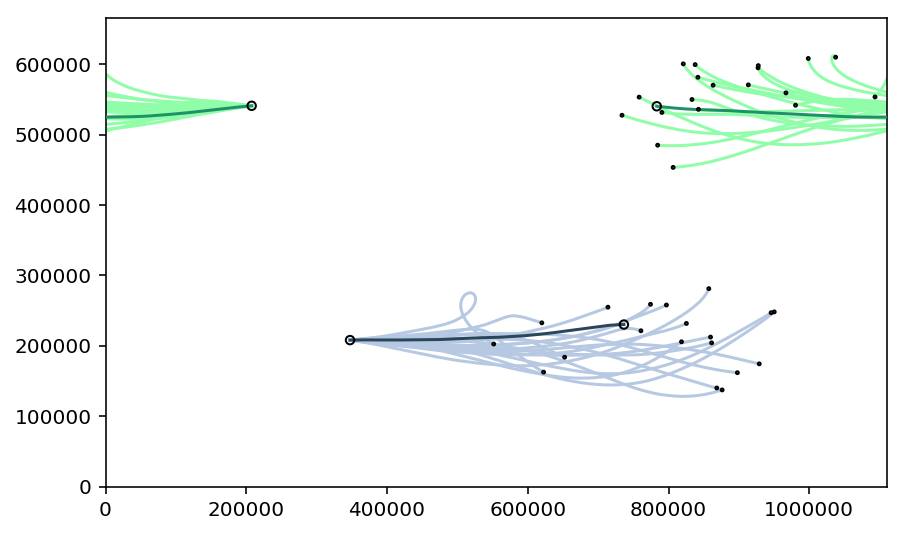

In [9]:

fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111)
emptyData =np.ma.masked_where(np.zeros((sim.ny,sim.nx)) > 1, 
                              np.zeros((sim.ny,sim.nx)))
ax.imshow(emptyData, origin="lower", 
          extent=[0, sim.nx*sim.dx, 0, sim.ny*sim.dy], cmap='binary')

# 
for path_set, color in zip([main_paths, extra_paths], ['xkcd:light blue grey', 'xkcd:foam green']):
    for paths in path_set:
        for path in paths:
            ax.plot(path[:,0], path[:,1], color=color)
        end_position   = paths[-1][-1,:]
        circ_end_forecast = matplotlib.patches.Circle((end_position[0], end_position[1]), 
                                                          2000, fill=False, zorder=10)
        ax.add_patch(circ_end_forecast)
        
for true_paths, color in zip([main_truth_path, extra_truth_path], ['xkcd:dark grey blue', 'xkcd:viridian']):
    for path in true_paths:
        ax.plot(path[:,0], path[:,1], color=color, zorder=5)
        
    start_pos = true_paths[0][0,:]
    end_pos   = true_paths[-1][-1,:]
    circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                           6000, fill=False, zorder=10)
    ax.add_patch(circ_start)

    circ_end = matplotlib.patches.Circle((end_pos[0], end_pos[1]), 
                                         6000, fill=False, zorder=10)
    ax.add_patch(circ_end)

    



print('hei')